In [ ]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Normalización , codificación y división
from sklearn.model_selection import GridSearchCV 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Librerías modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

import warnings

#Librerías para métricas
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from time import time 




Recopilación y exploración del conjunto de datos

In [ ]:
# Cargamos el training dataset
df = pd.read_csv('UNSW_NB15_training-set.csv',header=0) 
df.columns = ['id','dur','proto','service','state','spkts','dpkts',
                       'sbytes','dbytes','rate','sttl','dttl','sload','dload',
                       'sloss','dloss','sintpkt','dintpkt','sjit', 'djit',
                       'swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat',
                       'smean','dmean','trans_depth','res_bdy_len', 'ct_srv_dst',
                       'ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm',
                       'ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd',
                       'ct_src_ltm','ct_srv_src','is_sm_ips_ports','attack_cat','label'] 

#Limpieza de datos
# Eliminamos las columnas id y label
df= df.drop(['id'],1) 

# TRATAMIENTO DE VALORES DUPLICADOS O NULOS

# La columna ct_ftp_cmd tiene entradas invalidas.
# Las convertimos en numericas y sobreescribimos el resto con valores nulos
df['ct_ftp_cmd']=pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').fillna(0).astype('int64') 
df=df.fillna(0) 

# Eliminamos los espacios para evitar duplicados: 
df['attack_cat']=df['attack_cat'].str.strip()
df['attack_cat'].value_counts()

# Remplezamos los valores nulos de la columna 'attack_cat' por 'normal'
df['attack_cat'].fillna('Normal',inplace=True)
df['attack_cat'].value_counts()

#comprobamos que no falten valores
df.isna().sum()

df.info()
df.shape

# Reemplazamos '-' en state y service por 'otro'
df['state'] = df['state'].replace('-','otro')
df['service'] = df['service'].replace('-','otro')

df.groupby('attack_cat').size()

#Agrupamos Backdoor y Backdoors
df['attack_cat'] = df['attack_cat'].apply(lambda item: 'Backdoor' if item =='Backdoors' else item)
attack_by_cat = df.groupby('attack_cat').size().reset_index(name='counts')
attack_by_cat = attack_by_cat.sort_values(by = "counts", ascending=False) 
attack_by_cat = attack_by_cat.reset_index()
attack_by_cat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dur               82332 non-null  float64
 1   proto             82332 non-null  object 
 2   service           82332 non-null  object 
 3   state             82332 non-null  object 
 4   spkts             82332 non-null  int64  
 5   dpkts             82332 non-null  int64  
 6   sbytes            82332 non-null  int64  
 7   dbytes            82332 non-null  int64  
 8   rate              82332 non-null  float64
 9   sttl              82332 non-null  int64  
 10  dttl              82332 non-null  int64  
 11  sload             82332 non-null  float64
 12  dload             82332 non-null  float64
 13  sloss             82332 non-null  int64  
 14  dloss             82332 non-null  int64  
 15  sintpkt           82332 non-null  float64
 16  dintpkt           82332 non-null  float6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,index,attack_cat,counts
0,6,Normal,37000
1,5,Generic,18871
2,3,Exploits,11132
3,4,Fuzzers,6062
4,2,DoS,4089
5,7,Reconnaissance,3496
6,0,Analysis,677
7,1,Backdoor,583
8,8,Shellcode,378
9,9,Worms,44


Normalización y codificación

In [ ]:
#NORMALIZACIÓN


# Creamos un diccionario para signar un valor numérico a cada ataque
attack_cat_dic = {
    'Normal':0,
    'Generic':1,
    'Exploits':2,
    'Fuzzers':3,
    'DoS':4,
    'Reconnaissance':5,     
    'Analysis':6,          
    'Backdoor':7,
    'Shellcode':8,
    'Worms': 9
    }
df['attack_cat'] = df['attack_cat'].replace(attack_cat_dic)

#seleccionamos los valores númericos
df_num = df.select_dtypes(include=[np.number])
df_num.describe(include='all')




,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_src,is_sm_ips_ports,attack_cat,label
count,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,...,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,1.271923,0.550600
std,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,...,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,1.628266,0.497436
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000,1.000000
75%,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,2.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,...,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,9.000000,1.000000


In [ ]:
# Podamos los valores extremos para reducir la asimetría
#las caracteristicas con un valor max más de 10 veces el valor de la mediana
#se podan hasta el percentil 95

DEBUG =0

for cat in df_num.columns:
    if DEBUG == 1:
        print(cat)
        print('max = '+str(df_num[cat].max()))
        print('75th = '+str(df_num[cat].quantile(0.95)))
        print('median = '+str(df_num[cat].median()))
        print(df_num[cat].max()>10*df_num[cat].median())
        print('----------------------------------------------------')
    if df_num[cat].max()>10*df_num[cat].median() and df_num[cat].max()>10 :
        df[cat] = np.where(df[cat]<df[cat].quantile(0.95), df[cat], df[cat].quantile(0.95))

# mostar valores numericos y comprobamos
df_num = df.select_dtypes(include=[np.number])
df_num.describe(include='all')

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_src,is_sm_ips_ports,attack_cat,label
count,82332.000000,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,0.445016,11.84186,9.178424,1580.566135,2866.918367,71576.702810,180.967667,95.713003,4.649418e+07,3.105380e+05,...,3.388901,7.160679,0.008284,0.008381,0.092066,5.974809,8.832532,0.011126,1.271923,0.550600
std,0.672222,15.66461,14.504212,2948.850472,7525.606738,102631.946851,101.513358,116.667722,7.417784e+07,8.918691e+05,...,5.029129,10.481621,0.091171,0.092485,0.289121,6.867156,10.124902,0.104891,1.628266,0.497436
min,0.000000,1.00000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000008,2.00000,0.000000,114.000000,0.000000,28.606114,62.000000,0.000000,1.120247e+04,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,0.014138,6.00000,2.000000,534.000000,178.000000,2650.176667,254.000000,29.000000,5.770032e+05,2.112951e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000,1.000000
75%,0.719360,12.00000,10.000000,1280.000000,956.000000,111111.107200,254.000000,252.000000,6.514286e+07,1.585808e+04,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,2.000000,1.000000
max,2.403792,60.00000,54.000000,12472.000000,30622.000000,333333.321500,255.000000,253.000000,2.666667e+08,3.741446e+06,...,18.000000,37.000000,2.000000,2.000000,1.000000,25.000000,36.000000,1.000000,9.000000,1.000000


In [ ]:
#Aplicamos función logarimica ya que la mayoria de valores estan sesgados a la derecha
df_num = df.select_dtypes(include=[np.number])
df_before = df_num.copy()
DEBUG = 0
for cat in df_num.columns:
    if DEBUG == 1:
        print(cat)
        print('nunique = '+str(df_num[cat].nunique()))
        print(df_num[cat].nunique()>50)
        print('----------------------------------------------------')
    if df_num[cat].nunique()>50:
        if df_num[cat].min()==0:
            df[cat] = np.log(df[cat]+1)
        else:
            df[cat] = np.log(df[cat])

df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_src,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,otro,INT,0.693147,0.000000,6.206576,0.000000,11.417626,254,...,1.0,2.0,0,0,0.0,1.0,2.0,0,0,0
1,0.000008,udp,otro,INT,0.693147,0.000000,7.474205,0.000000,11.736077,254,...,1.0,2.0,0,0,0.0,1.0,2.0,0,0,0
2,0.000005,udp,otro,INT,0.693147,0.000000,6.973543,0.000000,12.206078,254,...,1.0,3.0,0,0,0.0,1.0,3.0,0,0,0
3,0.000006,udp,otro,INT,0.693147,0.000000,6.802395,0.000000,12.023757,254,...,1.0,3.0,0,0,0.0,2.0,3.0,0,0,0
4,0.000010,udp,otro,INT,0.693147,0.000000,7.661998,0.000000,11.512935,254,...,1.0,3.0,0,0,0.0,2.0,3.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,otro,INT,0.693147,0.000000,4.644391,0.000000,12.206078,254,...,1.0,2.0,0,0,0.0,2.0,1.0,0,0,0
82328,0.744838,tcp,otro,FIN,2.995732,2.197225,9.431241,5.872118,3.235145,254,...,1.0,1.0,0,0,0.0,3.0,2.0,0,0,0
82329,0.000000,arp,otro,INT,0.000000,0.000000,3.828641,0.000000,0.000000,0,...,1.0,1.0,0,0,0.0,1.0,1.0,1,0,0
82330,0.000000,arp,otro,INT,0.000000,0.000000,3.828641,0.000000,0.000000,0,...,1.0,1.0,0,0,0.0,1.0,1.0,1,0,0


In [ ]:
# Seleccionamos las etiquetas en las caracteristicas categóricas
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,131,13,7
top,tcp,otro,FIN
freq,43095,47153,39339


In [ ]:
#Reducimos a 6 las etiquetas categoricas
DEBUG = 0
for cat in df_cat.columns:
    if DEBUG == 1:
        print(cat)
        print('nunique = '+str(df_cat[cat].nunique()))
        print(df_cat[cat].nunique()>6)
        print(sum(df[cat].isin(df[cat].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if df_cat[cat].nunique()>6:
        df[cat] = np.where(df[cat].isin(df[cat].value_counts().head().index), df[cat], 'otros')
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,6,6,6
top,tcp,otro,FIN
freq,43095,47153,39339


In [ ]:
#Comprobamos que se han seleccionado las etiquetas correctas
df['proto'].value_counts().index

Index(['tcp', 'udp', 'otros', 'unas', 'arp', 'ospf'], dtype='object')

In [ ]:
#Definimos X e y

X = df.drop(['attack_cat', 'label'],1)

#Clasificación multiclase
y = df['attack_cat']

#Clasificación binaria
#y = df['label']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
#Creamos una lista con las categorias
categorias = list(X.columns)

#Comprobamos el tamaño
np.shape(X)


(82332, 42)

In [ ]:
#Aplicamos codificación One-Hot a las columnas categoricas
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['proto','service','state'])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

#Comprobamos el tamaño
np.shape(X)

(82332, 57)

In [ ]:
#Comrpobamos cuantas categorias hay
len(categorias)

42

In [ ]:
#completamos las que faltan
for label in list(df_cat['state'].value_counts().index)[::-1][1:]:
    categorias.insert(0,label)
    
for label in list(df_cat['service'].value_counts().index)[::-1][1:]:
    categorias.insert(0,label)
    
for label in list(df_cat['proto'].value_counts().index)[::-1][1:]:
    categorias.insert(0,label)

#Comprobamos 
len(categorias)

57

In [ ]:
#Dividimos el set de entramiento y el set de prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

df_cat.describe(include='all')

,proto,service,state
count,82332,82332,82332
unique,6,6,6
top,tcp,otro,FIN
freq,43095,47153,39339


In [ ]:
#Escalamos las caracteristicas para ponerlas del mismo orden de tamaño
#Aplicamos escalador estandar 
sc = StandardScaler()

#Empezamos a escalar a partir de la fila 18
#las primeras 18 corresponden a las catagorias codificadas
X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])
X_test[:, 18:] = sc.transform(X_test[:, 18:])

In [ ]:
#Comprobamos el tamaño de cada muestra
print(f"X_train_shape: {X_train.shape}, y_train_shape: {y_train.shape}")
print(f"X_test_shape: {X_test.shape}, y_test_shape: {y_test.shape}")

X_train_shape: (65865, 57), y_train_shape: (65865,)
X_test_shape: (16467, 57), y_test_shape: (16467,)


Modelos de clasificación

In [ ]:
#Multiclase
target_names = [
    'Normal',
    'Generic',
    'Exploits',
    'Fuzzers',
    'DoS',
    'Reconnaissance',   
    'Analysis',          
    'Backdoor',
    'Shellcode',
    'Worms'
]



In [ ]:
#Binaria
target_names = [
    'Normal',
    'Attack',
]

In [ ]:
resultados = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','Tiempo Ejecución'])

LOGISTIC REGRESSION

In [ ]:
# Entrenamos el logistic Regression
classifier = LogisticRegression()

tiempo_inicial = time()
classifier.fit(X_train, y_train)

 # Realizamos la clasificación con el set de test
logistic_regression_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

# Sacamos las métricas del clasificador:
print(classification_report(y_test,logistic_regression_pred,target_names=target_names))


El tiempo de ejecución fue de: 12.320 segundos
                precision    recall  f1-score   support

        Normal       0.89      0.97      0.93      7400
       Generic       0.99      0.96      0.98      3774
      Exploits       0.65      0.71      0.68      2227
       Fuzzers       0.62      0.50      0.55      1212
           DoS       0.41      0.30      0.35       818
Reconnaissance       0.60      0.61      0.60       699
      Analysis       0.00      0.00      0.00       135
      Backdoor       0.00      0.00      0.00       117
     Shellcode       0.00      0.00      0.00        76
         Worms       0.00      0.00      0.00         9

      accuracy                           0.83     16467
     macro avg       0.42      0.40      0.41     16467
  weighted avg       0.81      0.83      0.82     16467



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/loca

In [ ]:
accuracy = accuracy_score(y_test, logistic_regression_pred)
recall = recall_score(y_test, logistic_regression_pred, average='weighted')
precision = precision_score(y_test, logistic_regression_pred, average='weighted')
f1s = f1_score(y_test, logistic_regression_pred, average='weighted')
resultados.loc['Logistic Regression'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

In [ ]:
cm = confusion_matrix(y_test,logistic_regression_pred)
acc = accuracy_score(y_test, logistic_regression_pred)
acc

0.8294771360903626

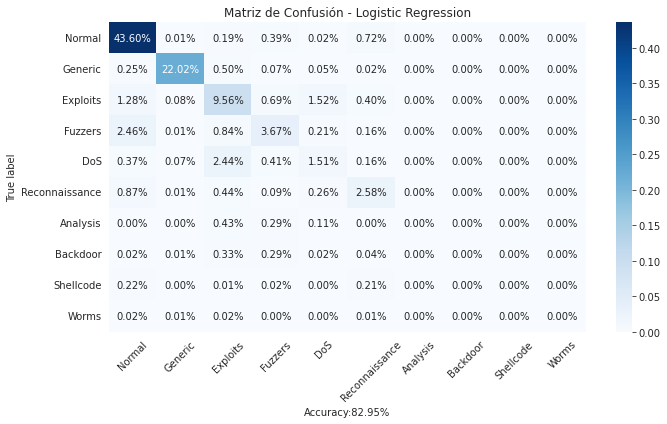

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - Logistic Regression')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

RANDOM FOREST

In [ ]:
# Entrenamos el Random Forest
classifier = RandomForestClassifier(n_estimators=400, n_jobs=3, verbose=1)

tiempo_inicial = time()
classifier.fit(X_train, y_train)

 # Realizamos la clasificación con el set de test
random_forest_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

# Sacamos las métricas del clasificador:
print(classification_report(y_test,random_forest_pred,target_names=target_names))

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   16.5s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   33.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.3s


El tiempo de ejecución fue de: 34.985 segundos
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97      7400
      Attack       0.98      0.97      0.98      9067

    accuracy                           0.98     16467
   macro avg       0.98      0.98      0.98     16467
weighted avg       0.98      0.98      0.98     16467



[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:    0.7s finished


In [ ]:
accuracy = accuracy_score(y_test, random_forest_pred)
recall = recall_score(y_test, random_forest_pred, average='weighted')
precision = precision_score(y_test, random_forest_pred, average='weighted')
f1s = f1_score(y_test, random_forest_pred, average='weighted')
resultados.loc['Random Forest'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
cm = confusion_matrix(y_test,random_forest_pred)
acc = accuracy_score(y_test, random_forest_pred)
acc

0.3312078702860266

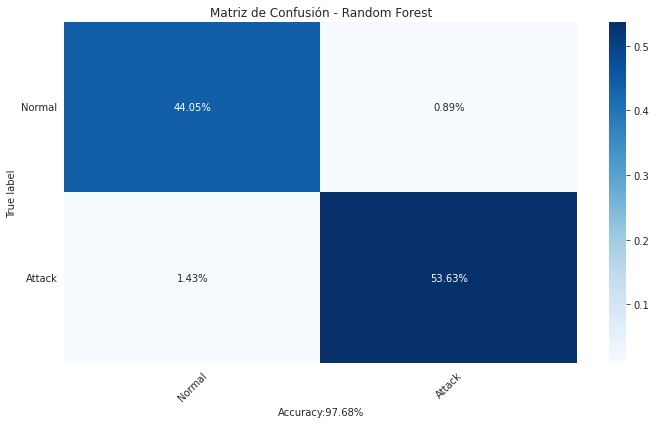

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - Random Forest')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

K NEIGHBORS

In [ ]:
# Entrenamos el random forest
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

tiempo_inicial = time()
classifier.fit(X_train, y_train)

# Realizamos la clasificación con el set de test
KNeighbors_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

print(classification_report(y_test, KNeighbors_pred, target_names=target_names))

El tiempo de ejecución fue de: 26.835 segundos
              precision    recall  f1-score   support

      Normal       0.93      0.97      0.95      7400
      Attack       0.97      0.94      0.95      9067

    accuracy                           0.95     16467
   macro avg       0.95      0.95      0.95     16467
weighted avg       0.95      0.95      0.95     16467



In [ ]:
accuracy = accuracy_score(y_test, KNeighbors_pred)
recall = recall_score(y_test, KNeighbors_pred, average='weighted')
precision = precision_score(y_test, KNeighbors_pred, average='weighted')
f1s = f1_score(y_test, KNeighbors_pred, average='weighted')
resultados.loc['K Neighbors'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

In [ ]:
cm = confusion_matrix(y_test,KNeighbors_pred)
acc = accuracy_score(y_test, KNeighbors_pred)
acc

0.9505678022712091

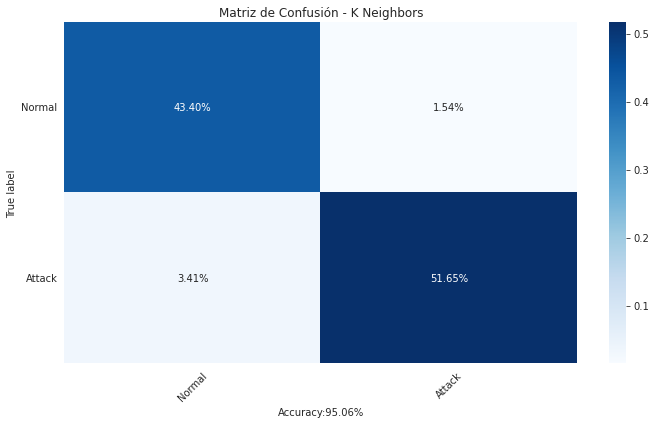

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - K Neighbors')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

DECISION TREE

In [ ]:
#Entrenamos con Decision Tree
classifier = DecisionTreeClassifier()

tiempo_inicial = time()
classifier.fit(X_train, y_train)

# Realizamos la clasificación con el set de test
decision_tree_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

print(classification_report(y_test, decision_tree_pred, target_names=target_names))

El tiempo de ejecución fue de: 1.168 segundos
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      7400
      Attack       0.97      0.97      0.97      9067

    accuracy                           0.97     16467
   macro avg       0.97      0.97      0.97     16467
weighted avg       0.97      0.97      0.97     16467



In [ ]:
accuracy = accuracy_score(y_test, decision_tree_pred)
recall = recall_score(y_test, decision_tree_pred, average='weighted')
precision = precision_score(y_test, decision_tree_pred, average='weighted')
f1s = f1_score(y_test, decision_tree_pred, average='weighted')
resultados.loc['Decision Tree'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

In [ ]:
cm = confusion_matrix(y_test,decision_tree_pred)
acc = accuracy_score(y_test, decision_tree_pred)
acc

0.966296228821279

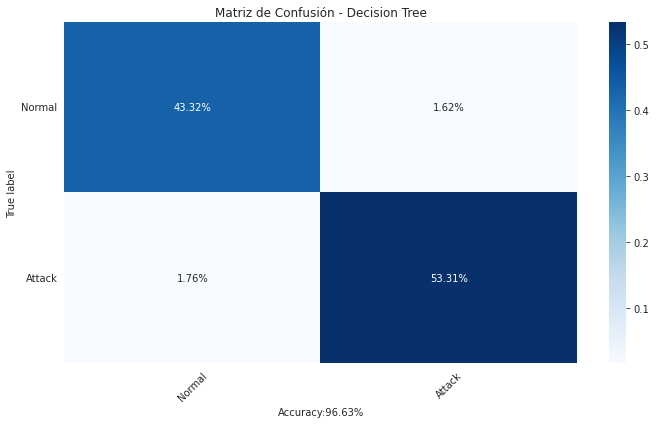

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - Decision Tree')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Extra Trees

In [ ]:
#Entrenamos con Extra Trees
classifier = ExtraTreesClassifier(random_state=0,n_jobs=-1)

tiempo_inicial = time()
classifier.fit(X_train, y_train)

# Realizamos la clasificación con el set de test
extra_trees_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

print(classification_report(y_test, extra_trees_pred, target_names=target_names))

El tiempo de ejecución fue de: 5.775 segundos
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      7400
      Attack       0.98      0.97      0.98      9067

    accuracy                           0.98     16467
   macro avg       0.97      0.98      0.97     16467
weighted avg       0.98      0.98      0.98     16467



In [ ]:
accuracy = accuracy_score(y_test, extra_trees_pred)
recall = recall_score(y_test, extra_trees_pred, average='weighted')
precision = precision_score(y_test, extra_trees_pred, average='weighted')
f1s = f1_score(y_test, extra_trees_pred, average='weighted')
resultados.loc['Extra Trees'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

In [ ]:
cm = confusion_matrix(y_test,extra_trees_pred)
acc = accuracy_score(y_test, extra_trees_pred)
acc

0.9751017185886925

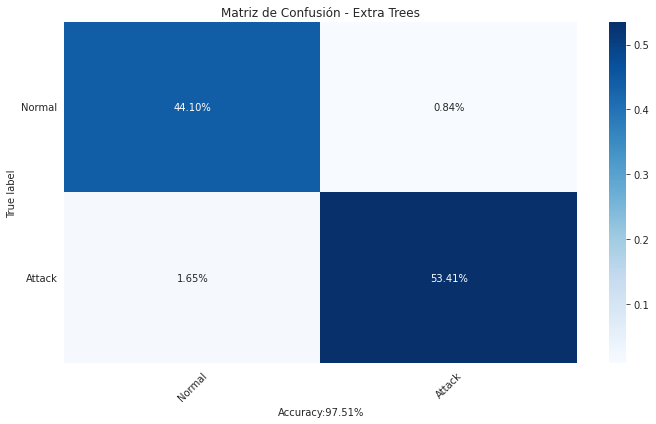

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - Extra Trees')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#Entrenamos con MLP
classifier = MLPClassifier(hidden_layer_sizes = (20,20,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train,y_train)

tiempo_inicial = time()
classifier.fit(X_train, y_train)

# Realizamos la clasificación con el set de test
mpl_pred = classifier.predict(X_test)
tiempo_final = time()
tiempo_ejecucion = tiempo_final - tiempo_inicial
print('El tiempo de ejecución fue de: %.3f segundos' % tiempo_ejecucion)

print(classification_report(y_test, mpl_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



El tiempo de ejecución fue de: 50.218 segundos
                precision    recall  f1-score   support

        Normal       0.94      0.98      0.96      7400
       Generic       1.00      0.96      0.98      3774
      Exploits       0.72      0.69      0.70      2227
       Fuzzers       0.62      0.66      0.64      1212
           DoS       0.43      0.50      0.46       818
Reconnaissance       0.81      0.78      0.80       699
      Analysis       0.83      0.04      0.07       135
      Backdoor       0.00      0.00      0.00       117
     Shellcode       0.51      0.29      0.37        76
         Worms       0.00      0.00      0.00         9

      accuracy                           0.86     16467
     macro avg       0.59      0.49      0.50     16467
  weighted avg       0.86      0.86      0.86     16467



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
accuracy = accuracy_score(y_test, mpl_pred)
recall = recall_score(y_test, mpl_pred, average='weighted')
precision = precision_score(y_test, mpl_pred, average='weighted')
f1s = f1_score(y_test, mpl_pred, average='weighted')
resultados.loc['MPL'] = [accuracy, recall, precision, f1s,tiempo_ejecucion]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
cm = confusion_matrix(y_test,mpl_pred)
acc = accuracy_score(y_test, mpl_pred)
acc

0.8617841744094249

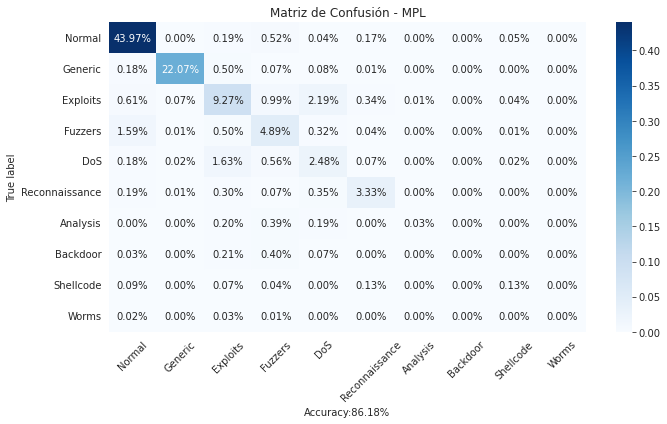

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Matriz de Confusión - MPL')
ax.set_xlabel(f'Accuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(target_names)
ax.xaxis.set_ticklabels(target_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Resultados

In [ ]:
resultados.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,Tiempo Ejecución
Logistic Regression,92.89%,92.89%,92.93%,92.90%,1.698455
Random Forest,97.68%,97.68%,97.69%,97.68%,34.984818
K Neighbors,95.06%,95.06%,95.14%,95.06%,26.834613
Decision Tree,96.63%,96.63%,96.63%,96.63%,1.168357
Extra Trees,97.51%,97.51%,97.53%,97.51%,5.775245
MPL,96.29%,96.29%,96.31%,96.29%,37.613620


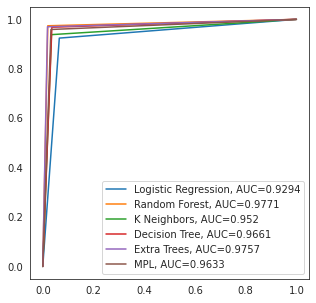

In [ ]:
#ROC

fpr, tpr, _ = metrics.roc_curve(y_test, logistic_regression_pred)
auc = round(metrics.roc_auc_score(y_test,logistic_regression_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, random_forest_pred)
auc = round(metrics.roc_auc_score(y_test,random_forest_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, KNeighbors_pred)
auc = round(metrics.roc_auc_score(y_test,KNeighbors_pred), 4)
plt.plot(fpr,tpr,label="K Neighbors, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, decision_tree_pred)
auc = round(metrics.roc_auc_score(y_test,decision_tree_pred), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test,extra_trees_pred)
auc = round(metrics.roc_auc_score(y_test,extra_trees_pred), 4)
plt.plot(fpr,tpr,label="Extra Trees, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, mpl_pred)
auc = round(metrics.roc_auc_score(y_test,mpl_pred), 4)
plt.plot(fpr,tpr,label="MPL, AUC="+str(auc))

#add legend
plt.legend()

MODELO HÍBRIDO

In [ ]:
final_pred = []
#Modelo Híbrido
for i in range(len(y_test)):
  if(decision_tree_pred[i] == random_forest_pred[i] == extra_trees_pred[i]):
    final_pred.append(decision_tree_pred[i])
  elif(decision_tree_pred[i] == random_forest_pred[i]):
    final_pred.append(decision_tree_pred[i])
  elif(decision_tree_pred[i] != random_forest_pred[i]):
    if(decision_tree_pred[i] == extra_trees_pred[i]):
      final_pred.append(decision_tree_pred[i])
    elif(extra_trees_pred[i] == random_forest_pred[i]):
      final_pred.append(random_forest_pred[i])
    else:
      final_pred.append(decision_tree_pred[i])

